### Table of Contents
- [Getting started](#Getting-Started)
    - [Set score baseline](#Set-score-baseline)
    - [Sampling](#Sampling)
- [Feature by Feature Exploration](#Feature-by-Feature-Exploration)
    - [What does my intuition tell me?](#What-does-my-intuition-tell-me?)
    - [Type](#Type)
    - Photo
    - Video
    - Description
    - Quantity
    - Age
    - Health
    - Breed
    - Color
    - Size and Fur
    - Gender
    - State
    - Rescuer
3. Model Tweaking

# Getting Started

In [1]:
# Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import RandomOverSampler
import warnings

# Options
warnings.filterwarnings(action='ignore')
sns.set_palette('YlGnBu')
%config InlineBackend.figure_format='retina'

In [2]:
def reset_dfs():
    global train_df, test_df
    train_df = pd.read_csv('../input/train/train.csv')
    test_df = pd.read_csv('../input/test/test.csv')
reset_dfs()

## Set score baseline
Let's put the cart before the horse. 
Let's get our data cleaning and feature building pipeline set up so that as we can progressively validate our hypotheses moving forward. 

The idea here is to produce the simplest, most basic predictions to use as a starting point for the rest of the process of score improvement. 

#### Explore the accompanying script, which contains the resulting data cleaning / feature building functions: 
https://www.kaggle.com/alhankeser/slow-and-steady-feature-building

According to the competition details, the evaluation metric is a **quadratic weighted kappa**, which sounds super complicated. Luckily, there is a function that I found [here](https://github.com/benhamner/Metrics/blob/master/Python/ml_metrics/quadratic_weighted_kappa.py) and that is used in few kernels. 

**Baseline Score: 0.07917**  
https://www.kaggle.com/alhankeser/slow-and-steady-feature-building?scriptVersionId=9976702

## Sampling
In typical beginner fashion, I'm going to use a new and shiny strategy that I just learned about [here](https://www.kaggle.com/rafjaa/resampling-strategies-for-imbalanced-datasets): sampling to overcome issues related to imbalances in the target feature counts.

**Is there an imbalance in the target feature?**

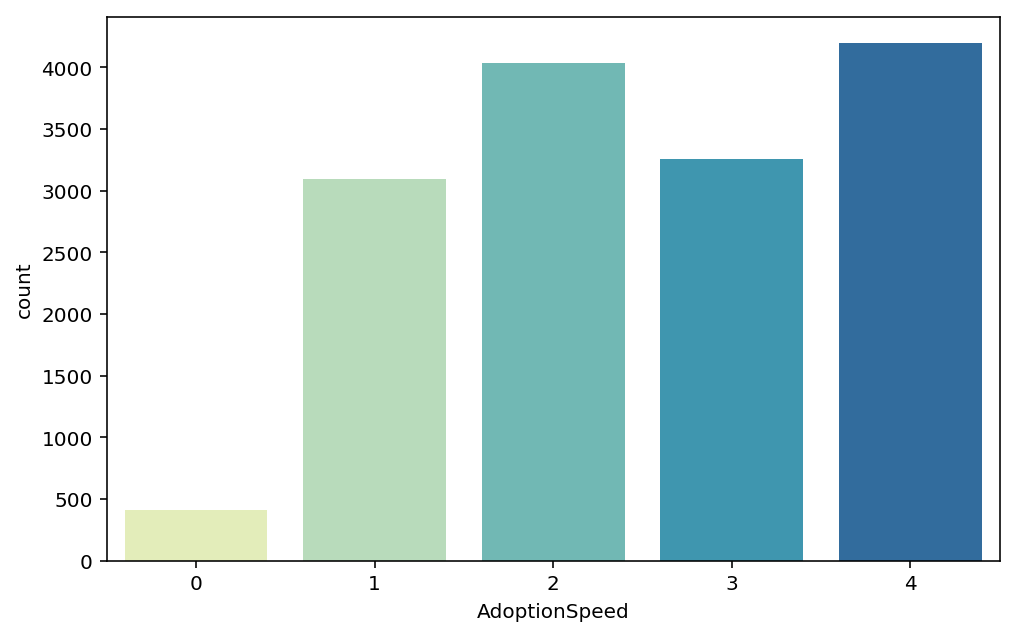

In [5]:
reset_dfs()
plt.figure(figsize=(8,5))
sns.countplot(train_df['AdoptionSpeed']);

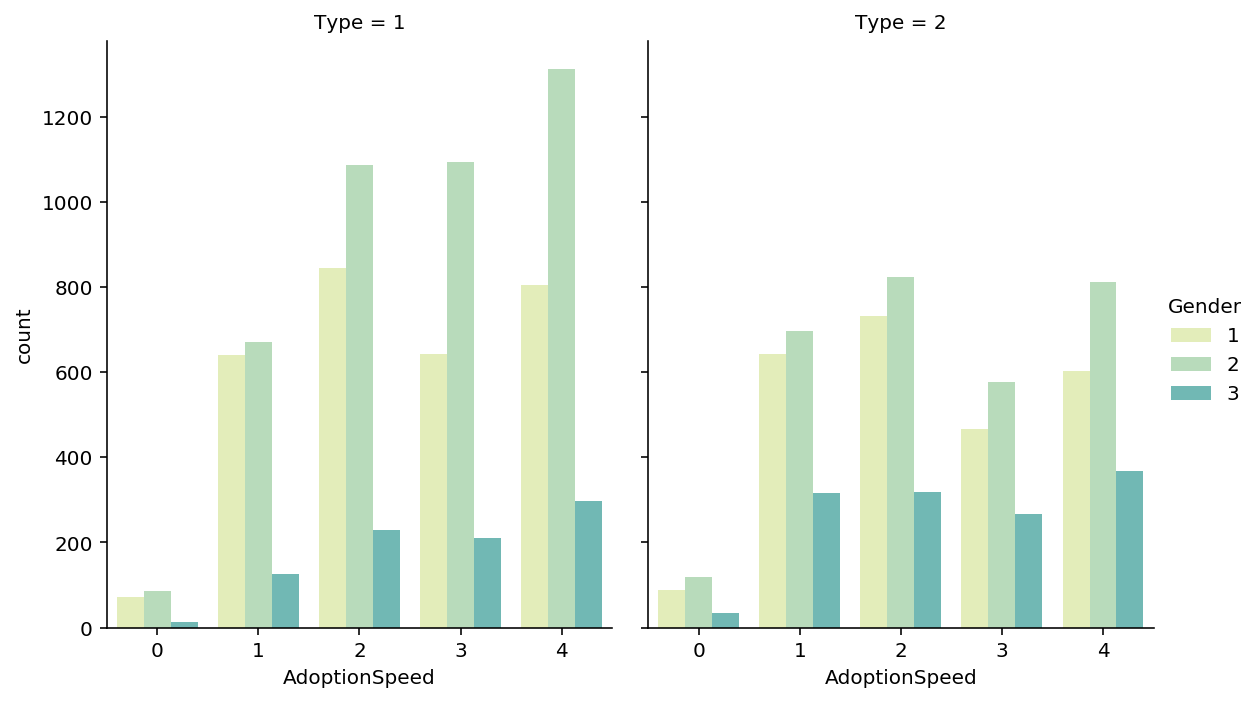

In [31]:
g = sns.catplot("AdoptionSpeed", col="Type",
                hue="Gender", data=train_df,
                kind="count", height=5, aspect=.8)

It appears that there is a low proportion of pets who are adopted on the day they was listed on PetFinder.

Let's look into a few oversampling strategies to address the problem statement described [here](https://www.kaggle.com/rafjaa/resampling-strategies-for-imbalanced-datasets). 

### df.sample()
There is a built-in pandas method to quickly under- or over-sample.  
Below, I've created a funtion to take a list of lists that contain the target values to resample from/to.  
The first item in each list is the target value being sample, either under or over, depending on whether there are more or less of the second item in each list. 

In [27]:
def sample(df, target_val_sets):
    for target_val_set in target_val_sets:
        df_class_0 = df[df['AdoptionSpeed'] == target_val_set[0]]
        count_1 = df['AdoptionSpeed'].value_counts()[target_val_set[1]]
        df_class_0_sampled = df_class_0.sample(count_1,replace='True')
        df = pd.merge(df.drop(df_class_0.index),
                      df_class_0_sampled, how='outer')
    return df

# Over sample where AdoptionSpeed == 0, to match the count of AdoptionSpeed == 1
train_df = sample(train_df, [[0, 1]])

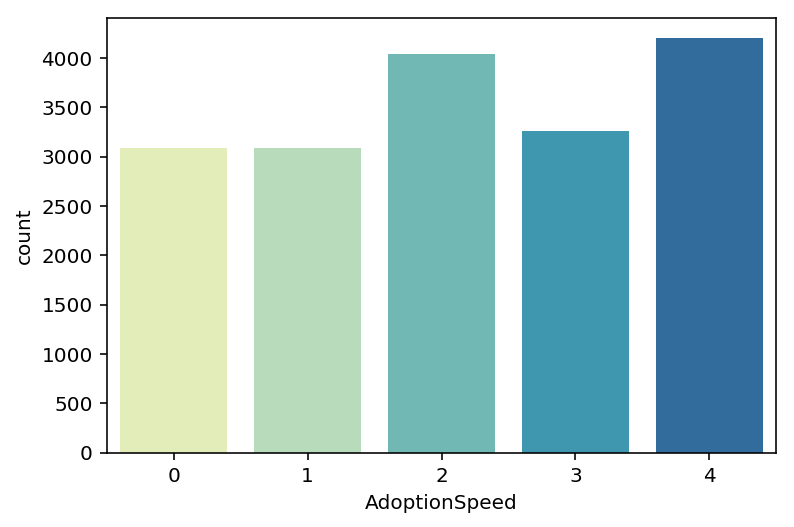

In [28]:
# Note how counts of 0 and 1 now match:
sns.countplot(train_df['AdoptionSpeed']);

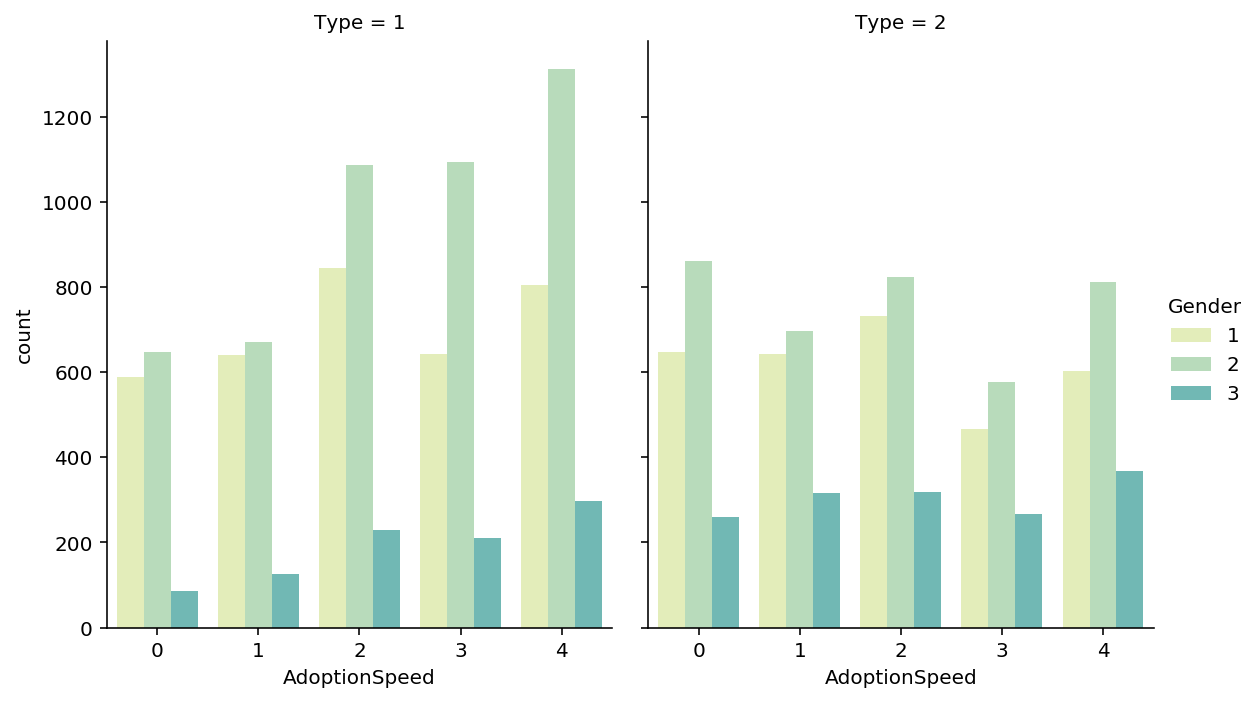

In [29]:
g = sns.catplot("AdoptionSpeed", col="Type",
                hue="Gender", data=train_df,
                kind="count", height=5, aspect=.8)

**What effect does randomly sampling using the pandas .sample() method have on our current local score**?  
Current Baseline: 0.07924  
New Score:  0.09349  
https://www.kaggle.com/alhankeser/slow-and-steady-feature-building?scriptVersionId=9976791  

### RandomUnderSampler()

In [13]:
X = train_df.drop('AdoptionSpeed', axis=1)
y = train_df['AdoptionSpeed']
from imblearn.over_sampling import RandomOverSampler

ros = RandomOverSampler(sampling_strategy='minority',
                                    random_state=1)
X_ros, y_ros = ros.fit_sample(X, y)

print(X_ros.shape[0] - X.shape[0], 'new random picked points')

3787 new random picked points


In [14]:
resampled_df = pd.DataFrame(list(X_ros), columns=train_df.drop('AdoptionSpeed', axis=1).columns)
resampled_df['AdoptionSpeed'] = list(y_ros)
resampled_df.head(2)
# values_df = pd.DataFrame(X_ros).reset_index
# resampled_df = columns_df.append(values_df)
# resampled_df.head()

,Type,Name,Age,Breed1,Breed2,Gender,Color1,Color2,Color3,MaturitySize,...,Health,Quantity,Fee,State,RescuerID,VideoAmt,Description,PetID,PhotoAmt,AdoptionSpeed
0,2,Nibble,3,299,0,1,1,7,0,1,...,1,1,100,41326,8480853f516546f6cf33aa88cd76c379,0,Nibble is a 3+ month old ball of cuteness. He ...,86e1089a3,1.0,2
1,2,No Name Yet,1,265,0,1,1,2,0,2,...,1,1,0,41401,3082c7125d8fb66f7dd4bff4192c8b14,0,I just found it alone yesterday near my apartm...,6296e909a,2.0,0


What is different here is that the minority ('AdoptionSpeed' == 0) is getting oversampled to match ('AdoptionSpeed' == 4). Not sure if that is good or bad...

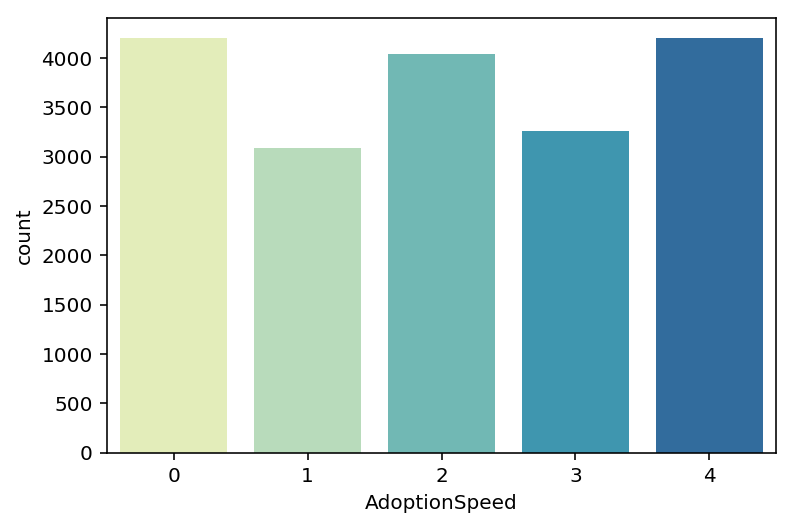

In [15]:
sns.countplot(resampled_df['AdoptionSpeed']);

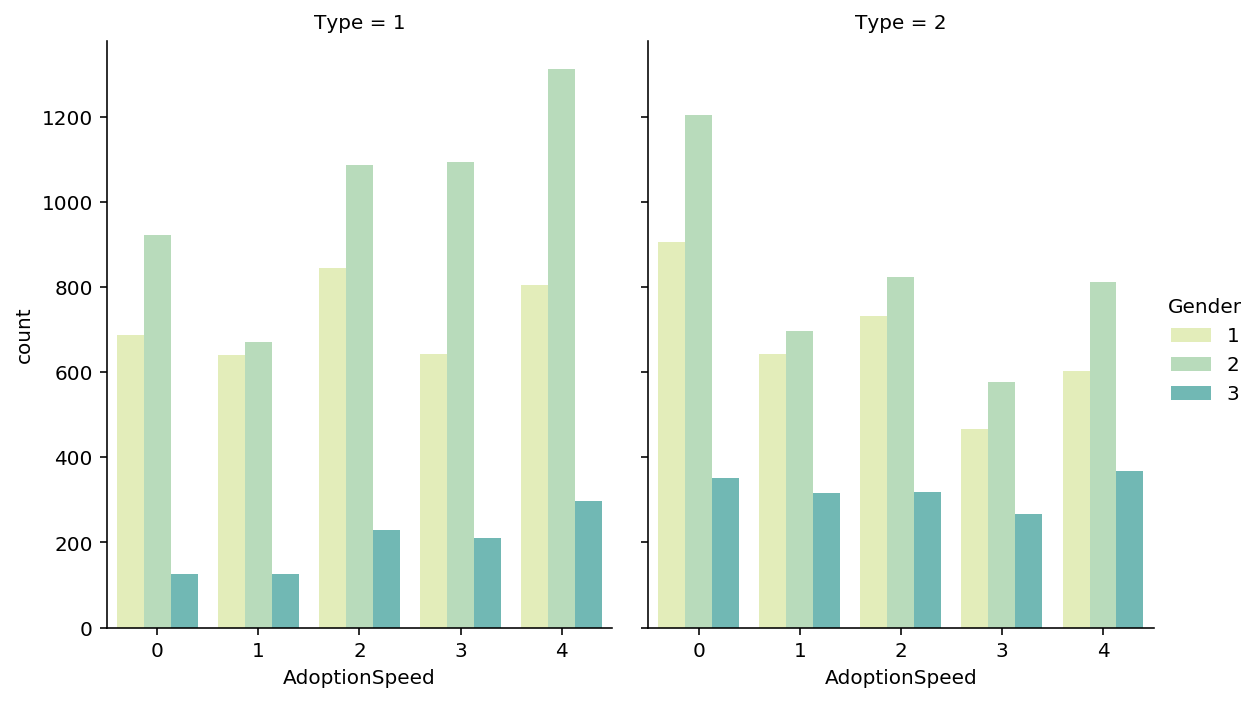

In [8]:
sns.catplot("AdoptionSpeed", col="Type",
                hue="Gender", data=resampled_df,
                kind="count", height=5, aspect=.8)

That certainly did *something*, right?  
Let's check our local score. 

**What effect does random over-sampling with imbalanced-learn affect have on our local score?**  
What effect does randomly sampling using the pandas .sample() method have on our current local score?  
Current Baseline: 0.09349  
New Score: 0.12413


# Feature by Feature Exploration